In [1]:
%pip install scipy matplotlib numpy torch torchvision StandardScaler

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.

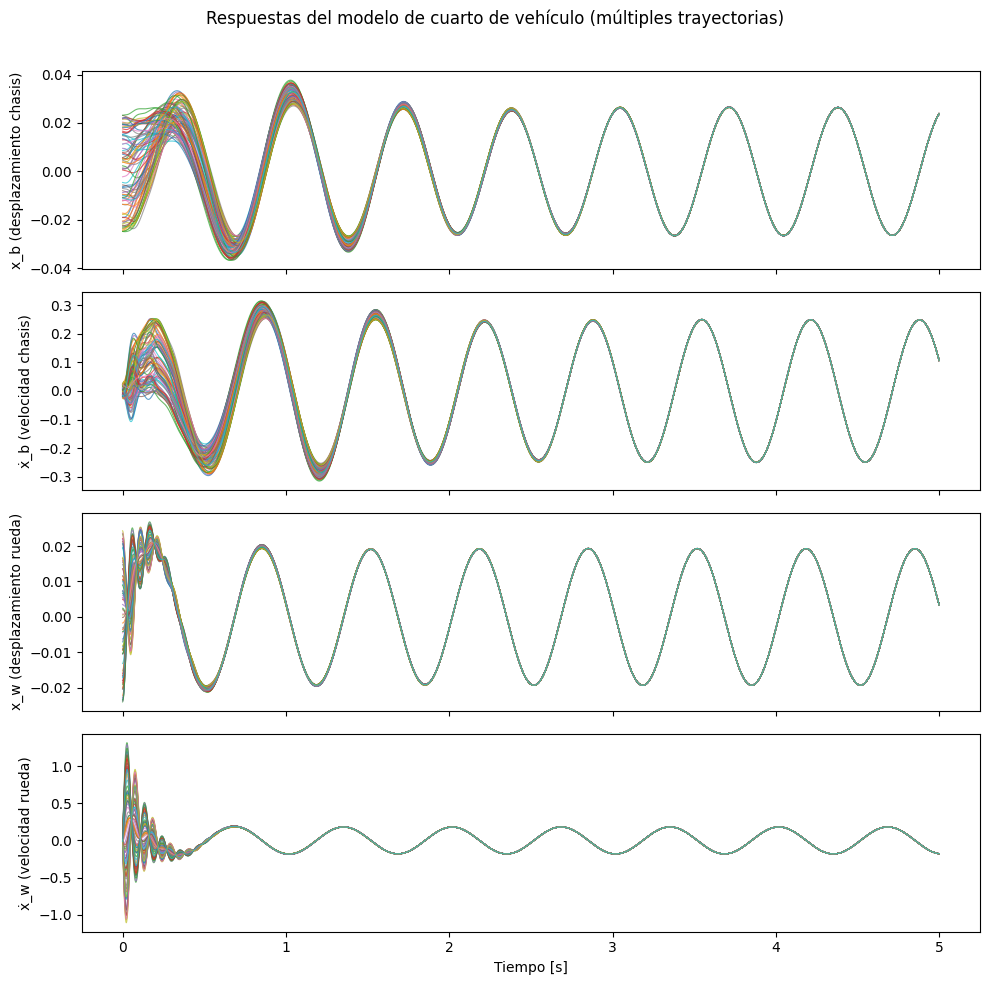

✅ Guardadas todas las trayectorias en 'trayectorias_cuarto_vehiculo.csv'


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# Parámetros del sistema
# -------------------------
mb = 290.0
mw = 59.0
ks = 16000.0
bs = 1000.0
kt = 190000.0
bt = 0.0   # si bt != 0, se usa xr_dot en la dinámica

# Perfil de carretera (entrada) y su derivada analítica
A = 0.02
f = 1.5
omega = 2*np.pi*f

def xr(t):
    return A * np.sin(omega * t)

def xr_dot(t):
    return A * omega * np.cos(omega * t)

# Fuerzas externas (puedes modificarlas)
def Fs_fun(t):
    return 0.0

def Fw_fun(t):
    return 0.0

# -------------------------
# Dinámica continua (primer orden)
# -------------------------
def cuarto_vehiculo_ode(t, x):
    # x = [x_b, x_b_dot, x_w, x_w_dot]
    x1, x2, x3, x4 = x
    xr_t = xr(t)
    xr_dot_t = xr_dot(t) if bt != 0.0 else 0.0
    Fs = Fs_fun(t)
    Fw = Fw_fun(t)

    dx1 = x2
    dx2 = (-ks*(x1 - x3) - bs*(x2 - x4) + Fs) / mb
    dx3 = x4
    dx4 = ( ks*(x1 - x3) + bs*(x2 - x4) - kt*(x3 - xr_t) - bt*(x4 - xr_dot_t) + Fw ) / mw

    return [dx1, dx2, dx3, dx4]

# -------------------------
# Simulación: varias trayectorias
# -------------------------
np.random.seed(42)
dt = 0.001
t_final = 5.0
t_eval = np.arange(0, t_final+dt, dt)

num_trayectorias = 80
all_trajs = []

# Crear figuras para cada variable
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
labels = ["x_b (desplazamiento chasis)",
          "ẋ_b (velocidad chasis)",
          "x_w (desplazamiento rueda)",
          "ẋ_w (velocidad rueda)"]

for j in range(num_trayectorias):
    x0 = 0.05*(np.random.rand(4) - 0.5)
    sol = solve_ivp(cuarto_vehiculo_ode, [0, t_final], x0, t_eval=t_eval, rtol=1e-8, atol=1e-10)
    X = sol.y.T

    # Graficar cada variable en su subplot
    for i in range(4):
        axs[i].plot(sol.t, X[:, i], linewidth=0.8, alpha=0.7)
        axs[i].set_ylabel(labels[i])

    df = pd.DataFrame({
        't': sol.t,
        'x_b': X[:,0],
        'x_b_dot': X[:,1],
        'x_w': X[:,2],
        'x_w_dot': X[:,3],
        'xr': xr(sol.t),
        'Fs': Fs_fun(sol.t)
    })
    df['traj_id'] = j
    all_trajs.append(df)

axs[-1].set_xlabel("Tiempo [s]")
plt.suptitle("Respuestas del modelo de cuarto de vehículo (múltiples trayectorias)")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# -------------------------
# (Opcional) Guardar CSV
# -------------------------
big = pd.concat(all_trajs, ignore_index=True)
big.to_csv('trayectorias_cuarto_vehiculo.csv', index=False)
print("✅ Guardadas todas las trayectorias en 'trayectorias_cuarto_vehiculo.csv'")


Red neuronal creada:
- Entrada: 3 variables (tiempo, posición carretera, fuerza)
- Salida: 4 variables (estados del vehículo)
- Datos de entrenamiento: 320064 muestras
- Datos de validación: 80016 muestras
Iniciando entrenamiento...
Época [50/200], Train Loss: 0.08641451, Val Loss: 0.06873420
Época [100/200], Train Loss: 0.08388916, Val Loss: 0.06744026
Early stopping en época 145
✅ Entrenamiento completado!


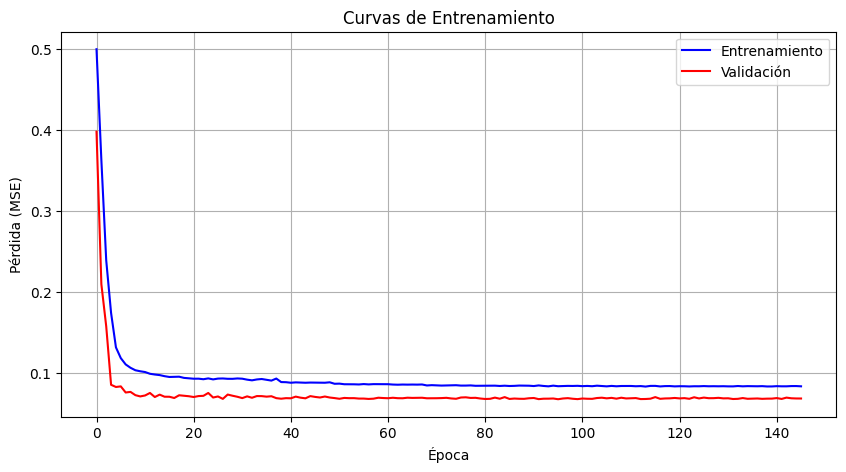

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim

# Definir el dataset personalizado
class VehicleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Preparar los datos
# Usar como entrada: tiempo, posición carretera, fuerza externa
X = big[['t', 'xr', 'Fs']].values
# Predecir las 4 variables de estado
y = big[['x_b', 'x_b_dot', 'x_w', 'x_w_dot']].values

# Normalizar los datos
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Crear datasets y dataloaders
train_dataset = VehicleDataset(X_train, y_train)
val_dataset = VehicleDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Definir la red neuronal
class VehicleNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=4):
        super(VehicleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size//2),
            
            nn.Linear(hidden_size//2, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

# Crear el modelo
model = VehicleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

print("Red neuronal creada:")
print(f"- Entrada: {X.shape[1]} variables (tiempo, posición carretera, fuerza)")
print(f"- Salida: {y.shape[1]} variables (estados del vehículo)")
print(f"- Datos de entrenamiento: {X_train.shape[0]} muestras")
print(f"- Datos de validación: {X_val.shape[0]} muestras")

# Entrenamiento de la red neuronal
print("Iniciando entrenamiento...")
epochs = 200
best_loss = float('inf')
patience = 50
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        # Guardar mejor modelo
        torch.save(model.state_dict(), 'best_vehicle_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en época {epoch}")
            break
    
    # Scheduler
    scheduler.step(val_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f'Época [{epoch+1}/{epochs}], Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')

# Cargar mejor modelo
model.load_state_dict(torch.load('best_vehicle_model.pth'))
print("✅ Entrenamiento completado!")

# Graficar curvas de pérdida
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Entrenamiento', color='blue')
plt.plot(val_losses, label='Validación', color='red')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.title('Curvas de Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def predict_trajectory_nn(model, x0, t_eval, scaler_X, scaler_y):
    """
    Predice trayectoria usando la red neuronal entrenada
    x0: condiciones iniciales [x_b(0), x_b_dot(0), x_w(0), x_w_dot(0)]
    """
    model.eval()
    trajectory = np.zeros((len(t_eval), 4))
    trajectory[0] = x0.copy()
    
    with torch.no_grad():
        for i in range(len(t_eval)):
            # Preparar entrada: [tiempo, posición carretera, fuerza]
            t_current = t_eval[i]
            xr_current = xr(t_current)
            Fs_current = Fs_fun(t_current)
            
            input_features = np.array([t_current, xr_current, Fs_current]).reshape(1, -1)
            input_scaled = scaler_X.transform(input_features)
            input_tensor = torch.FloatTensor(input_scaled)
            
            # Predicción
            output_scaled = model(input_tensor).numpy()
            output = scaler_y.inverse_transform(output_scaled)
            trajectory[i] = output.flatten()
    
    return trajectory

# Función alternativa para predicción secuencial (más precisa)
def predict_trajectory_sequential(model, x0, t_eval, scaler_X, scaler_y):
    """Predicción secuencial usando estado anterior como información"""
    model.eval()
    trajectory = np.zeros((len(t_eval), 4))
    trajectory[0] = x0.copy()
    
    # Crear características expandidas incluyendo estados
    current_state = x0.copy()
    
    with torch.no_grad():
        for i in range(1, len(t_eval)):
            t_current = t_eval[i]
            xr_current = xr(t_current)
            Fs_current = Fs_fun(t_current)
            
            # Usar estado actual + entradas externas
            input_features = np.array([t_current, xr_current, Fs_current]).reshape(1, -1)
            input_scaled = scaler_X.transform(input_features)
            input_tensor = torch.FloatTensor(input_scaled)
            
            # Predicción
            output_scaled = model(input_tensor).numpy()
            output = scaler_y.inverse_transform(output_scaled)
            trajectory[i] = output.flatten()
            current_state = output.flatten()
    
    return trajectory

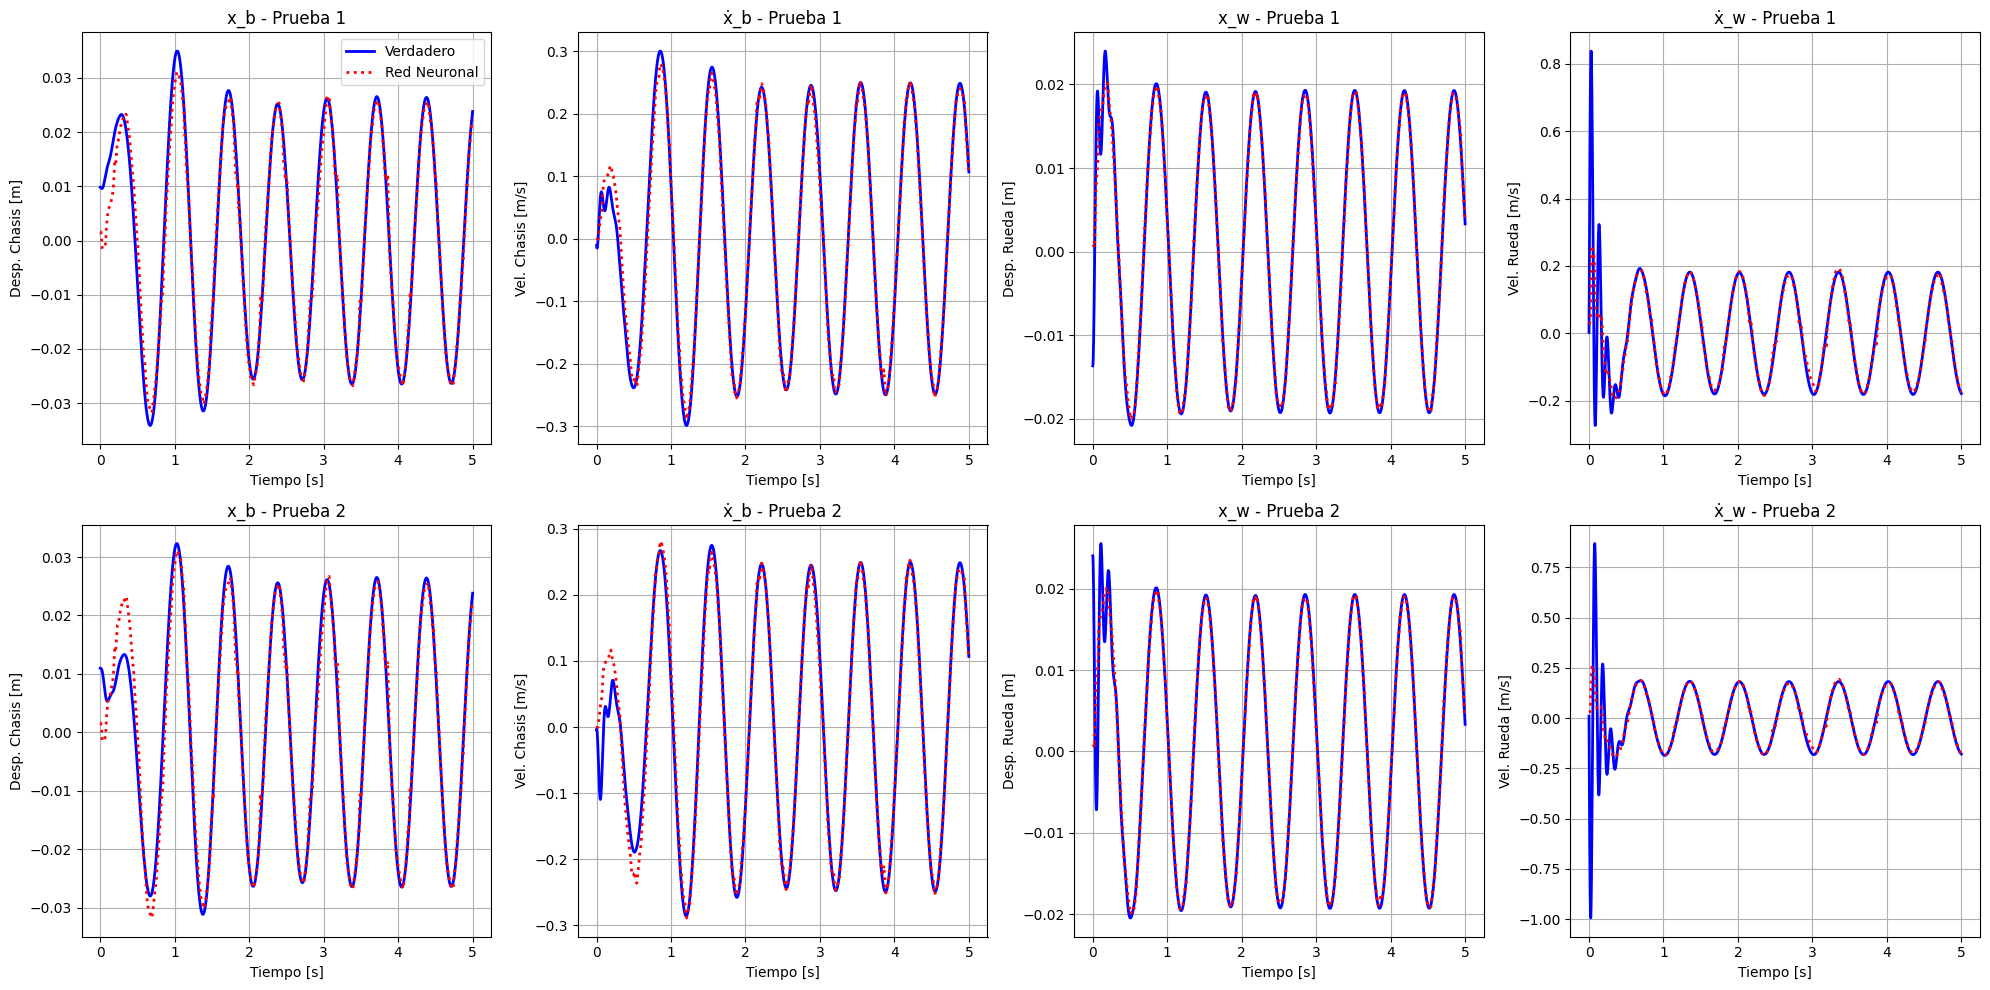


MÉTRICAS DE ERROR DETALLADAS

📊 PRUEBA 1:
  Mean Squared Error (MSE): 0.00112529
  Mean Absolute Error (MAE): 0.00791990
  Error Máximo Absoluto: 0.71471899

  Errores promedio por variable:
    x_b: MAE = 0.00181868, Max = 0.01255347
    ẋ_b: MAE = 0.01097335, Max = 0.06186475
    x_w: MAE = 0.00051879, Max = 0.01424090
    ẋ_w: MAE = 0.01836878, Max = 0.71471899

📊 PRUEBA 2:
  Mean Squared Error (MSE): 0.00292632
  Mean Absolute Error (MAE): 0.01043578
  Error Máximo Absoluto: 1.13778424

  Errores promedio por variable:
    x_b: MAE = 0.00182441, Max = 0.01192873
    ẋ_b: MAE = 0.01295555, Max = 0.14331455
    x_w: MAE = 0.00065221, Max = 0.02345474
    ẋ_w: MAE = 0.02631094, Max = 1.13778424

📈 ESTADÍSTICAS GENERALES:
  MSE promedio: 0.00202581 ± 0.00090051
  MAE promedio: 0.00917784 ± 0.00125794
  Error máximo promedio: 0.92625162 ± 0.21153263


In [11]:
# Pruebas con diferentes condiciones iniciales
np.random.seed(123)  # Para reproducibilidad

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
test_results = []

for test_idx in range(2):
    # Generar condición inicial de prueba
    x0_test = 0.05 * (np.random.rand(4) - 0.5)
    
    # Solución verdadera (ODE)
    sol_true = solve_ivp(cuarto_vehiculo_ode, [0, t_final], x0_test, 
                        t_eval=t_eval, rtol=1e-8, atol=1e-10)
    true_trajectory = sol_true.y.T
    
    # Predicción con red neuronal
    pred_trajectory = predict_trajectory_nn(model, x0_test, t_eval, scaler_X, scaler_y)
    
    # Calcular errores
    mse = np.mean((true_trajectory - pred_trajectory)**2)
    mae = np.mean(np.abs(true_trajectory - pred_trajectory))
    max_error = np.max(np.abs(true_trajectory - pred_trajectory))
    
    # Errores por variable
    errors_by_var = np.mean(np.abs(true_trajectory - pred_trajectory), axis=0)
    max_errors_by_var = np.max(np.abs(true_trajectory - pred_trajectory), axis=0)
    
    test_results.append({
        'mse': mse,
        'mae': mae,
        'max_error': max_error,
        'errors_by_var': errors_by_var,
        'max_errors_by_var': max_errors_by_var
    })
    
    # Graficar cada variable de estado
    var_names = ['x_b', 'ẋ_b', 'x_w', 'ẋ_w']
    var_labels = ['Desp. Chasis [m]', 'Vel. Chasis [m/s]', 'Desp. Rueda [m]', 'Vel. Rueda [m/s]']
    
    for var_idx in range(4):
        axes[test_idx, var_idx].plot(t_eval, true_trajectory[:, var_idx], 'b-', 
                                   linewidth=2, label='Verdadero')
        axes[test_idx, var_idx].plot(t_eval, pred_trajectory[:, var_idx], 'r:', 
                                   linewidth=2, label='Red Neuronal')
        axes[test_idx, var_idx].grid(True)
        axes[test_idx, var_idx].set_title(f'{var_names[var_idx]} - Prueba {test_idx + 1}')
        axes[test_idx, var_idx].set_xlabel('Tiempo [s]')
        axes[test_idx, var_idx].set_ylabel(var_labels[var_idx])
        if test_idx == 0 and var_idx == 0:
            axes[test_idx, var_idx].legend()

plt.tight_layout()
plt.show()

# Mostrar métricas de error detalladas
print("\n" + "="*60)
print("MÉTRICAS DE ERROR DETALLADAS")
print("="*60)

for test_idx, result in enumerate(test_results):
    print(f"\n📊 PRUEBA {test_idx + 1}:")
    print(f"  Mean Squared Error (MSE): {result['mse']:.8f}")
    print(f"  Mean Absolute Error (MAE): {result['mae']:.8f}")
    print(f"  Error Máximo Absoluto: {result['max_error']:.8f}")
    
    print(f"\n  Errores promedio por variable:")
    var_names = ['x_b', 'ẋ_b', 'x_w', 'ẋ_w']
    for i, var_name in enumerate(var_names):
        print(f"    {var_name}: MAE = {result['errors_by_var'][i]:.8f}, Max = {result['max_errors_by_var'][i]:.8f}")

# Estadísticas generales sobre múltiples pruebas
print(f"\n📈 ESTADÍSTICAS GENERALES:")
all_mse = [r['mse'] for r in test_results]
all_mae = [r['mae'] for r in test_results]
all_max = [r['max_error'] for r in test_results]

print(f"  MSE promedio: {np.mean(all_mse):.8f} ± {np.std(all_mse):.8f}")
print(f"  MAE promedio: {np.mean(all_mae):.8f} ± {np.std(all_mae):.8f}")
print(f"  Error máximo promedio: {np.mean(all_max):.8f} ± {np.std(all_max):.8f}")

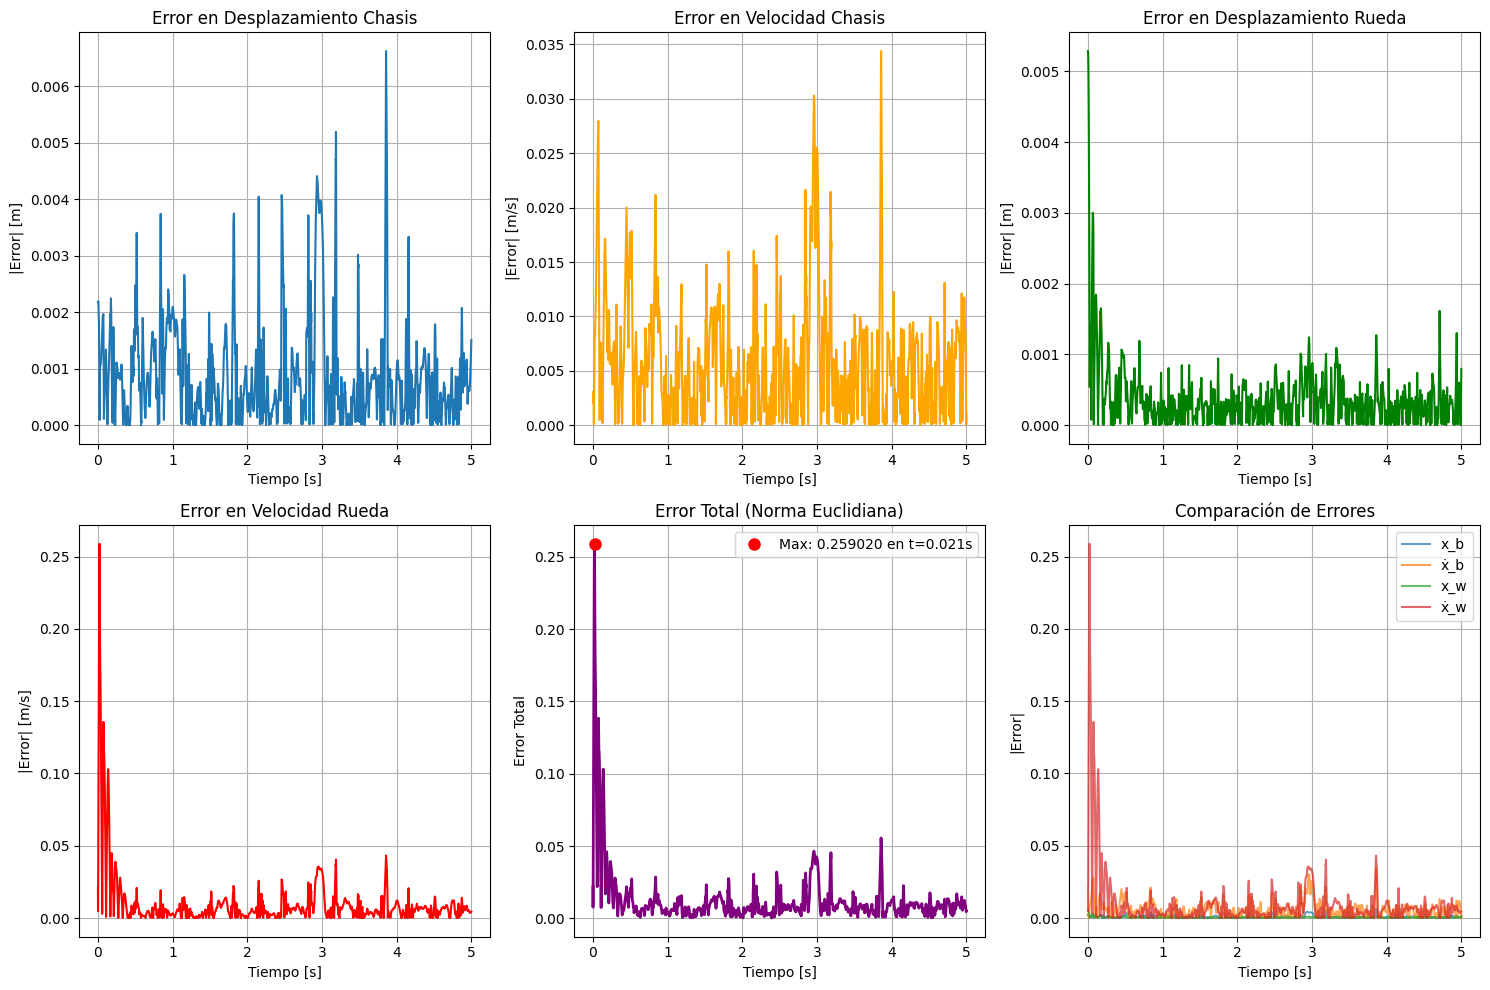


🎯 ANÁLISIS TEMPORAL DEL ERROR:
  Error máximo total: 0.25902046
  Tiempo del error máximo: 0.021 segundos
  Error promedio total: 0.01255532
  Error mínimo total: 0.00028471


In [12]:
# Análisis de error a lo largo del tiempo
x0_analysis = 0.03 * (np.random.rand(4) - 0.5)
sol_true = solve_ivp(cuarto_vehiculo_ode, [0, t_final], x0_analysis, 
                    t_eval=t_eval, rtol=1e-8, atol=1e-10)
true_traj = sol_true.y.T
pred_traj = predict_trajectory_nn(model, x0_analysis, t_eval, scaler_X, scaler_y)

# Calcular errores por tiempo
error_x1 = np.abs(true_traj[:, 0] - pred_traj[:, 0])
error_x2 = np.abs(true_traj[:, 1] - pred_traj[:, 1])  
error_x3 = np.abs(true_traj[:, 2] - pred_traj[:, 2])
error_x4 = np.abs(true_traj[:, 3] - pred_traj[:, 3])
total_error = np.sqrt(np.sum((true_traj - pred_traj)**2, axis=1))

plt.figure(figsize=(15, 10))

# Error por variable
plt.subplot(2, 3, 1)
plt.plot(t_eval, error_x1, label='x_b')
plt.title('Error en Desplazamiento Chasis')
plt.xlabel('Tiempo [s]')
plt.ylabel('|Error| [m]')
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(t_eval, error_x2, label='ẋ_b', color='orange')
plt.title('Error en Velocidad Chasis')
plt.xlabel('Tiempo [s]')
plt.ylabel('|Error| [m/s]')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(t_eval, error_x3, label='x_w', color='green')
plt.title('Error en Desplazamiento Rueda')
plt.xlabel('Tiempo [s]')
plt.ylabel('|Error| [m]')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(t_eval, error_x4, label='ẋ_w', color='red')
plt.title('Error en Velocidad Rueda')
plt.xlabel('Tiempo [s]')
plt.ylabel('|Error| [m/s]')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(t_eval, total_error, color='purple', linewidth=2)
plt.title('Error Total (Norma Euclidiana)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Error Total')
plt.grid(True)

# Marcar error máximo
max_idx = np.argmax(total_error)
plt.plot(t_eval[max_idx], total_error[max_idx], 'ro', markersize=8, 
         label=f'Max: {total_error[max_idx]:.6f} en t={t_eval[max_idx]:.3f}s')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(t_eval, error_x1, label='x_b', alpha=0.7)
plt.plot(t_eval, error_x2, label='ẋ_b', alpha=0.7)
plt.plot(t_eval, error_x3, label='x_w', alpha=0.7)
plt.plot(t_eval, error_x4, label='ẋ_w', alpha=0.7)
plt.title('Comparación de Errores')
plt.xlabel('Tiempo [s]')
plt.ylabel('|Error|')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n🎯 ANÁLISIS TEMPORAL DEL ERROR:")
print(f"  Error máximo total: {np.max(total_error):.8f}")
print(f"  Tiempo del error máximo: {t_eval[max_idx]:.3f} segundos")
print(f"  Error promedio total: {np.mean(total_error):.8f}")
print(f"  Error mínimo total: {np.min(total_error):.8f}")